In [1]:
#!sudo /opt/conda/bin/conda install conda-build -y

In [2]:
#!sudo /opt/conda/bin/conda-develop -n QML-QPF PATH /workspaces/QML-QPF/mosaiQue

In [3]:

#import tensorflow as tf
#from tensorflow import keras
import mosaique as mq
from concurrent.futures import ProcessPoolExecutor, as_completed
import itertools
import numpy as np
import pennylane as qml
import os
import time
import tensorflow as tf
from matplotlib import pyplot as plt
from mosaique.models.operation import OperationLayer
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'


def operation():
    dev = qml.device("default.qubit.tf", wires=4)
    @qml.qnode(dev, interface='tf')
    def cnot(inputs):
        inputs = inputs * np.pi
        qml.AngleEmbedding(inputs[:,...], wires=range(4), rotation='Y')

        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[2, 3])

        # Measurement producing 4 classical output values
        return [qml.expval(qml.PauliZ(j)) for j in range(4)]
    return cnot

2024-11-24 17:09:43.767751: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-24 17:09:44.493690: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:

from tensorflow import keras
mnist_dataset = keras.datasets.mnist
tr_layer = mq.ConvolutionLayer4x4("mnist_train2")
te_layer = mq.ConvolutionLayer4x4("mnist_test2")
(tr_images, tr_labels), (te_images, te_labels) = mnist_dataset.load_data()
(tr_images, tr_labels), (te_images, te_labels) = (tr_images[:20], tr_labels[:20]), (te_images[:20], te_labels[:20])
tr_layer.fit(tr_images)
te_layer.fit(te_images)



(20, 14, 14)
(20, 28, 28)
(20, 196, 4)


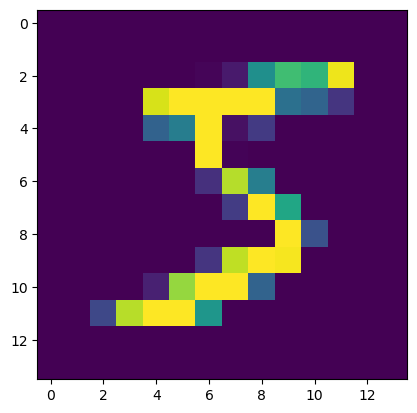

In [5]:
print((tr_images[:, 1::2, 1::2]).shape)

(tr_images[:, 1::2, 1::2]) = 255

print(tr_images.shape)

tr_images2 = tr_layer.transform(tr_images)

te_images2 = te_layer.transform(te_images)

print(tr_images2.shape)

plt.imshow(tr_images2[0,:,1].reshape((-1,14)))



In [6]:
permutations = np.asarray(list(itertools.permutations(range(4))))

op = OperationLayer(operation())
#predict = op.pre_op.predict(tr_images2[:,:,permutations[-1]])
predict = op.pre_op.predict(tr_images2,batch_size=5)

#print(tr_images2[:,:,permutations[-1]].shape)
print(predict.shape)
#print(permutations[-1])


2024-11-24 17:09:45.646996: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:238] Using CUDA malloc Async allocator for GPU: 0
2024-11-24 17:09:45.647282: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6795 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:b3:00.0, compute capability: 7.5
I0000 00:00:1732468186.380353   79514 service.cc:145] XLA service 0x7033d0013790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732468186.380391   79514 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2024-11-24 17:09:46.406651: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-24 17:09:46.486005: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(20, 4, 196)


I0000 00:00:1732468186.795390   79514 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


-1.9852474e-05 255.00003


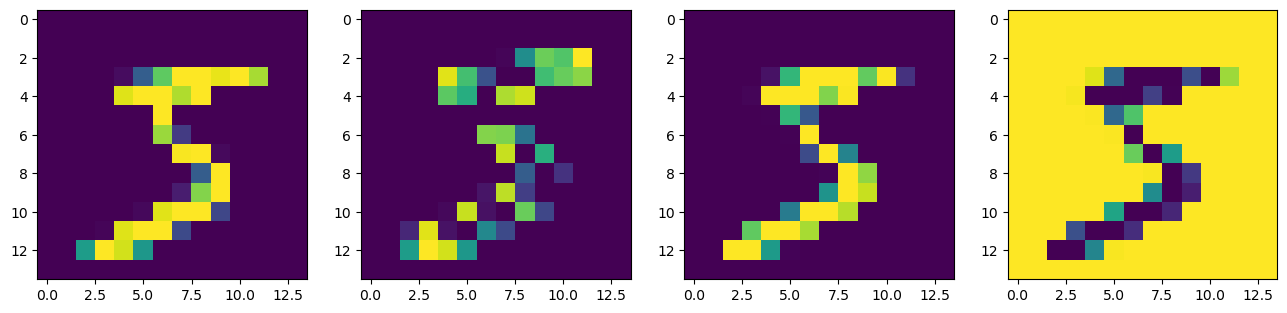

In [7]:
_min, _max = np.amin(predict), np.amax(predict)
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

print(_min,_max)

# Plot all output channels for quantum cnot
for c in range(4):
    axes[c].imshow(predict[0,c,:].reshape((14,14)),vmin = _min, vmax = _max)

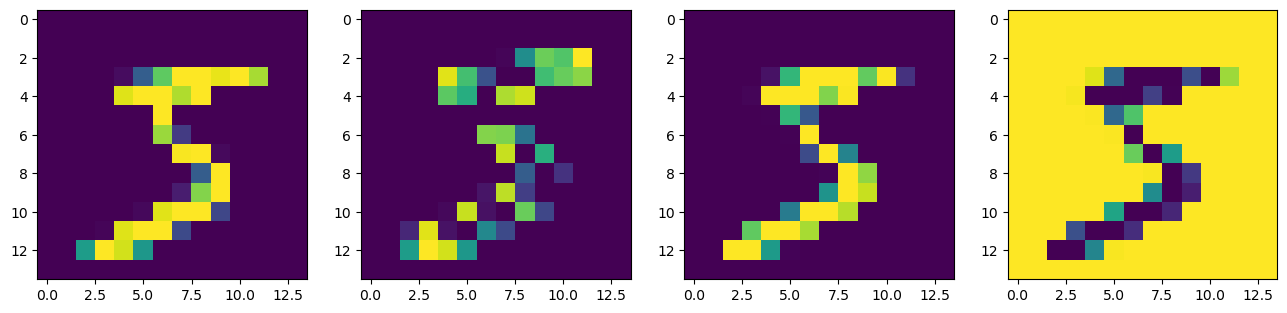

In [8]:
post = (tr_layer.post_transform(predict))
_min, _max = np.amin(post), np.amax(post)
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Plot all output channels for quantum cnot
for c in range(4):
    axes[c].imshow(post[0,:,:,c],vmin = _min, vmax = _max)

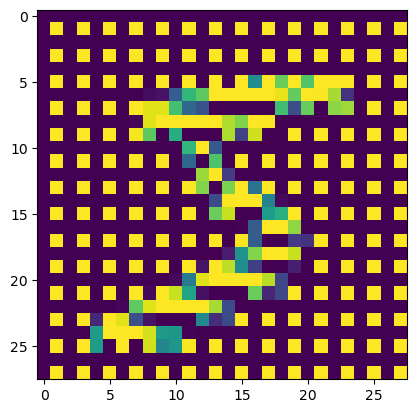

In [9]:
post = (tr_layer.post_transform(predict))

#post[:,:,:,1] = 0

plt.imshow((tr_layer.channel_merge(post))[0,:,:],vmin = _min, vmax = _max)